In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

data = torch.load('../../data/BlocksWorld/attr_score/qwen2-7B.pt')
tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen2-7B-Instruct')

/data/miniforge3/envs/agent-planning/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_2466752/3557003419.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start se

In [5]:
from typing import Union, Tuple
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def plot_token_attr(
    token_attr, input_tokens, output_tokens, show: bool = True
) -> Union[None, Tuple[plt.Figure, plt.Axes]]:
    """
    Generate a matplotlib plot for visualizing the attribution of output tokens.

    Args:
        token_attr (torch.Tensor): The tensor containing token attributions.
        input_tokens (List[str]): List of input tokens used as x-axis labels.
        output_tokens (List[str]): List of output tokens used as y-axis labels.
        show (bool, optional): Whether to display the plot immediately or return the figure and axis.
            Default: True.

    Returns:
        Union[None, Tuple[plt.Figure, plt.Axes]]: None if `show` is True, otherwise returns the figure and axes.
    """
    if token_attr is None:
        raise ValueError(
            "token_attr is None (no token-level attribution was performed). Please use plot_seq_attr "
            "instead for the sequence-level attribution plot."
        )

    # Ensure the token_attr is on the CPU
    token_attr = token_attr.cpu()

    # Convert token_attr to a NumPy array for visualization
    data = token_attr.numpy()

    # Define a custom colormap with the specified positive and negative colors
    positive_color = (102 / 255, 194 / 255, 165 / 255)  # RGB normalized to 0-1 range
    negative_color = (251 / 255, 84 / 255, 56 / 255)   # RGB normalized to 0-1 range
    zero_color = (1, 1, 1)  # White for neutral (zero) values

    # Create the custom colormap using LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list(
        "custom_cmap",
        [negative_color, zero_color, positive_color],
        N=256
    )

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(max(data.shape[1] * 1.3, 6.4), max(data.shape[0] / 2.5, 4.8)))

    # Plot the heatmap with the custom colormap and normalized color range centered around zero
    im = ax.imshow(data, cmap=cmap, vmin=-1, vmax=1, aspect=0.5)

    # Create a colorbar with a label
    cbar = fig.colorbar(im, ax=ax, fraction=0.024, pad=0.04) 
    cbar.ax.set_ylabel("Attribution Score", rotation=-90, va="bottom", fontsize=15)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

    # Set tick labels for x and y axes
    ax.set_xticks(np.arange(data.shape[1]), labels=input_tokens)
    ax.set_yticks(np.arange(data.shape[0]), labels=output_tokens)

    # Move the x-axis labels to the top
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")
    # plt.setp(ax.get_xticklabels(), rotation=0, rotation_mode="anchor")

    # Add text annotations on each cell with color contrast adjustment
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            color = "black" if 0.2 < im.norm(val) < 0.8 else "white"
            ax.text(
                j, i, f"{val:.4f}",
                ha="center", va="center", color=color
            )

    # Show the plot or return the figure and axis based on the `show` flag
    if show:
        plt.show()
        return None
    else:
        return fig, ax

In [6]:
block_list =   {"a": "red block", "b": "blue block", "c": "orange block", "d": "yellow block",
   "e": "white block", "f": "magenta block", "g": "black block", "h": "cyan block",
   "i": "green block", "j": "violet block", "k": "silver block", "l": "gold block" }.values()

def blocksworld_postprocess(output_tokens, token_attr):
    output_len = len(output_tokens)
    new_output_tokens = []
    new_token_attr = []
    for i in range(output_len):
        if 'pick' in output_tokens[i].lower() and 'up' in output_tokens[i+1].lower():
            new_output_tokens.append('pick up')
            new_token_attr.append((token_attr[i] + token_attr[i+1]))
            
        elif 'put' in output_tokens[i].lower() and 'down' in output_tokens[i+1].lower():
            new_output_tokens.append('put down')
            new_token_attr.append((token_attr[i] + token_attr[i+1]))

        elif 'stack' in output_tokens[i].lower() and i>0 and 'un' not in output_tokens[i-1].lower():
            new_output_tokens.append('stack')
            new_token_attr.append(token_attr[i])

        elif 'un' in output_tokens[i].lower() and 'stack' in output_tokens[i+1].lower():
            new_output_tokens.append(tokenizer.convert_tokens_to_string(output_tokens[i:i+2]).strip().lower())
            new_token_attr.append((token_attr[i] + token_attr[i+1]))

        elif 'block' in output_tokens[i].lower() and i>0:
            block = tokenizer.convert_tokens_to_string(output_tokens[i-1:i+1]).strip().lower()
            if  block in block_list:
                new_output_tokens.append(block)
                new_token_attr.append((token_attr[i-1]+token_attr[i]))

    renew_output_tokens = []
    renew_token_attr = []

    n_output_tokens = len(new_output_tokens)

    for i in range(n_output_tokens):
        if new_output_tokens[i] in ['pick up','put down'] and i+1<n_output_tokens and 'block' in new_output_tokens[i+1]:
            renew_output_tokens.append(new_output_tokens[i] + ' ' + new_output_tokens[i+1])
            mean_tensors = (new_token_attr[i] + new_token_attr[i+1])
            renew_token_attr.append(mean_tensors)
        elif new_output_tokens[i] in ['stack','unstack'] and i+1<n_output_tokens and 'block' in new_output_tokens[i+1] and i+2<n_output_tokens and 'block' in new_output_tokens[i+2]:
            renew_output_tokens.append(new_output_tokens[i] + ' ' + new_output_tokens[i+1] + ' ' + new_output_tokens[i+2])
            mean_tensors = (new_token_attr[i] + new_token_attr[i+1] + new_token_attr[i+2])
            renew_token_attr.append(mean_tensors)

    return renew_output_tokens[:], renew_token_attr[:]


In [7]:
from copy import deepcopy

input_tokens = data['blocksworld'][0]['input_tokens']
# input_tokens[-1] = '[STATEMENT]' + '\n[QUESTION]'

action_tensor_mapping = {'pick up': [], 'unstack': [], 'put down': [], 'stack': []}

for instance in data['blocksworld'] + data['blocksworld_3']:
    # if instance['is_correct']:
        outputs = instance['output_tokens']
        attrs = instance['attr']

        new_output_tokens, new_token_attr = blocksworld_postprocess(outputs, attrs)

        output_tokens = new_output_tokens
        token_attr = new_token_attr

        for output, attr in zip(output_tokens, token_attr):
            if 'pick up' in output:
                action_tensor_mapping['pick up'].append(attr)
            elif 'put down' in output:
                action_tensor_mapping['put down'].append(attr)
            elif 'unstack' in output:
                action_tensor_mapping['unstack'].append(attr)
            elif 'stack' in output:
                action_tensor_mapping['stack'].append(attr)
    
mapping = {'pick up': None, 'unstack': None, 'put down': None, 'stack': None}

for action in action_tensor_mapping:
    # Filter out tensors that are all zeros
    non_zero_tensors = [tensor for tensor in action_tensor_mapping[action]]
    
    # If there are still tensors after filtering, proceed with the following operations
    if len(non_zero_tensors) > 0:
        # Stack the non-zero tensors into a new tensor
        stacked_tensors = torch.stack(non_zero_tensors)
        
        # Sum the stacked tensor
        mean_tensors = torch.mean(stacked_tensors, dim=0)
        
        # Calculate the maximum absolute value along the first dimension (row) of each tensor for normalization
        max_abs_vals, _ = torch.max(torch.abs(mean_tensors), dim=0, keepdim=True)
        
        # Normalize using the maximum absolute value, keeping the original sign, and avoid division by zero
        normalized_tensors = torch.where(max_abs_vals == 0, mean_tensors, mean_tensors / max_abs_vals)
        
        # Save the normalized tensor
        mapping[action] = mean_tensors
    else:
        # If there are no non-zero tensors, save None or another default value
        mapping[action] = None


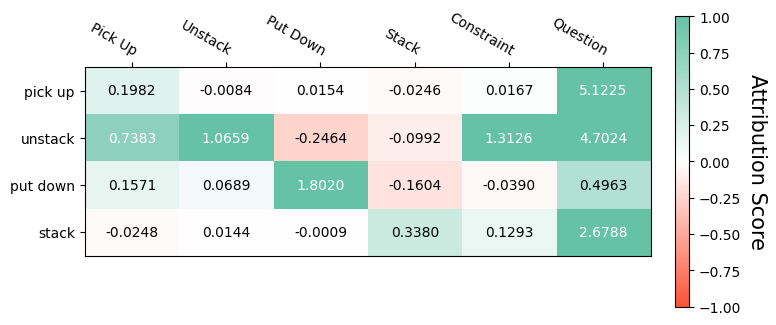

In [12]:
fig,ax = plot_token_attr(torch.stack([x for x in mapping.values()]),['Pick Up','Unstack','Put Down','Stack','Constraint','Question'], mapping.keys(), False)